In [223]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [224]:
data = pd.read_excel("./Sample - Superstore.xls")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# 머신러닝 실습
    - State 별로 Profit의 차이를 알고싶다.

### 데이터 분석

In [225]:
#.info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [226]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [227]:
# State 값 개수 확인
data["State"].unique()

array(['Kentucky', 'California', 'Florida', 'North Carolina',
       'Washington', 'Texas', 'Wisconsin', 'Utah', 'Nebraska',
       'Pennsylvania', 'Illinois', 'Minnesota', 'Michigan', 'Delaware',
       'Indiana', 'New York', 'Arizona', 'Virginia', 'Tennessee',
       'Alabama', 'South Carolina', 'Oregon', 'Colorado', 'Iowa', 'Ohio',
       'Missouri', 'Oklahoma', 'New Mexico', 'Louisiana', 'Connecticut',
       'New Jersey', 'Massachusetts', 'Georgia', 'Nevada', 'Rhode Island',
       'Mississippi', 'Arkansas', 'Montana', 'New Hampshire', 'Maryland',
       'District of Columbia', 'Kansas', 'Vermont', 'Maine',
       'South Dakota', 'Idaho', 'North Dakota', 'Wyoming',
       'West Virginia'], dtype=object)

In [228]:
# Sub-Category 값 개수 확인
len(data["Sub-Category"].unique())

17

### 데이터 전처리

In [229]:
# 대조용 원본데이터 , 작업용 데이터(df)구분
df = data[["State","Sales","Sub-Category"]]
df

,State,Sales,Sub-Category
0,Kentucky,261.9600,Bookcases
1,Kentucky,731.9400,Chairs
2,California,14.6200,Labels
3,Florida,957.5775,Tables
4,Florida,22.3680,Storage
...,...,...,...
9989,Florida,25.2480,Furnishings
9990,California,91.9600,Furnishings
9991,California,258.5760,Phones
9992,California,29.6000,Paper


In [230]:
#명목변수를 숫자로 치환
def encoder(series):
    dic = dict(zip(series.unique(), range(len(series.unique()))))
    result = series.apply(lambda x : dic[x])
    return result

In [231]:
for i in df[["State","Sub-Category"]]:
    df[i] = encoder(df[i])

C:\Users\user\AppData\Local\Temp\ipykernel_14444\1266262221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = encoder(df[i])


In [240]:
df

,State,Sales,Sub-Category
0,0,261.9600,0
1,0,731.9400,1
2,1,14.6200,2
3,2,957.5775,3
4,2,22.3680,4
...,...,...,...
9989,2,25.2480,5
9990,1,91.9600,5
9991,1,258.5760,7
9992,1,29.6000,10


In [232]:
#하나만 바꿀때
#df["State"] = encoder(df["State"])
#df

In [233]:
#독립변수 ,종속변수 설정
X = df[["State","Sales"]]
y = df["Sub-Category"]

### EDA

array([[<AxesSubplot:xlabel='State', ylabel='State'>,
        <AxesSubplot:xlabel='Sales', ylabel='State'>,
        <AxesSubplot:xlabel='Sub-Category', ylabel='State'>],
       [<AxesSubplot:xlabel='State', ylabel='Sales'>,
        <AxesSubplot:xlabel='Sales', ylabel='Sales'>,
        <AxesSubplot:xlabel='Sub-Category', ylabel='Sales'>],
       [<AxesSubplot:xlabel='State', ylabel='Sub-Category'>,
        <AxesSubplot:xlabel='Sales', ylabel='Sub-Category'>,
        <AxesSubplot:xlabel='Sub-Category', ylabel='Sub-Category'>]],
      dtype=object)

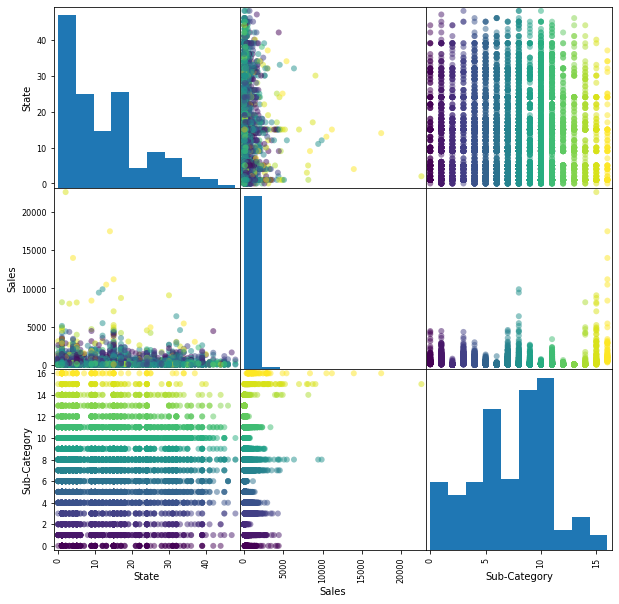

In [234]:
pd.plotting.scatter_matrix(df, figsize=(10,10),c = np.array(y) ,marker="o" )

### train,test split

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### 모델 선정

In [236]:
modelR = RandomForestClassifier()
modelGD = GradientBoostingClassifier()
modelK = KNeighborsClassifier(n_neighbors=5)
modelXG= xgb.XGBClassifier()
modelLG = LGBMClassifier()

### 모델학습

In [237]:
modelR.fit(X_train, y_train)
modelGD.fit(X_train, y_train)
modelK.fit(X_train, y_train)
modelXG.fit(X_train, y_train)
modelLG.fit(X_train, y_train)


LGBMClassifier()

### 모델 평가

In [239]:
print("KNN 모델 성능: " , modelK.score(X_test,y_test))
print("GD 모델 성능: " , modelGD.score(X_test,y_test))
print("Rtree 모델 성능: " , modelR.score(X_test,y_test))
print("XG 모델 성능: " , modelXG.score(X_test,y_test))
print("LGBM 모델 성능: " , modelLG.score(X_test,y_test))

KNN 모델 성능:  0.2000800320128051
GD 모델 성능:  0.25970388155262103
Rtree 모델 성능:  0.22328931572629052
XG 모델 성능:  0.28731492597038816
LGBM 모델 성능:  0.21648659463785513


### 시각화

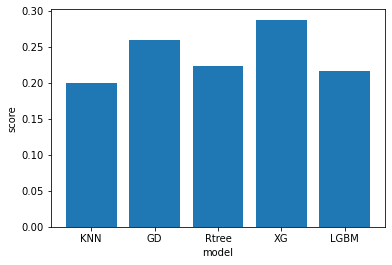

In [242]:
models = ["KNN","GD","Rtree","XG","LGBM"]
scr = [modelK.score(X_test,y_test),modelGD.score(X_test,y_test), modelR.score(X_test,y_test), 
       modelXG.score(X_test,y_test), modelLG.score(X_test,y_test)]
plt.bar(models,scr)
plt.xlabel("model")
plt.ylabel("score")
plt.show()